In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

ModuleNotFoundError: No module named 'pandas'

In [ ]:
np.random.seed(42)

# 1. Portfolio Size
N = 10000

# 2. Simulate Demographics & Risk Factors
# Issue Age: Normal with center 42, clipped between 25 and 65
issue_age = np.clip(np.random.normal(
    loc=42, scale=10, size=N), 25, 65).astype(int)

# Gender, Smoker, Diabetic status
gender = np.random.choice(['M', 'F'], size=N, p=[0.55, 0.45])
smoker = np.random.choice([0, 1], size=N, p=[0.80, 0.20])
diabetic_prob = np.clip((issue_age - 20) / 150, 0.01, 0.30)
diabetic = np.random.binomial(n=1, p=diabetic_prob)  # correlation with age
# Face Amount: Lognormal distribution
face_amount = np.round(np.random.lognormal(
    mean=np.log(150000), sigma=0.6, size=N), -3)
face_amount = np.clip(face_amount, 50000, 2000000)  # Clip between 50k and 2M

# Issue Dates: Random dates between Jan 1, 2015 and Dec 31, 2024
start_date = datetime(2015, 1, 1).toordinal()
end_date = datetime(2024, 12, 31).toordinal()
issue_dates_ord = np.random.randint(start_date, end_date, N)
issue_dates = [datetime.fromordinal(d) for d in issue_dates_ord]

# Simulate The Actuarial "Time-to-Event"

# Gompertz Law parameters (mu_x = B * c^x)
B = 0.00005
c = 1.09

# Excess mortality
# Males +10% risk, Smokers +50% risk, Diabetics +40% risk
M = 1.0 + (gender == 'M') * 0.10 + smoker * 0.50 + diabetic * 0.40

# Simulate Time-to-Death (T_d) using Inverse Transform Sampling for Gompertz
U_death = np.random.uniform(0, 1, N)
# Math: T_d = (1 / ln(c)) * ln[1 - (ln(c) * ln(1-U)) / (B * c^x * M)]
ln_c = np.log(c)
time_to_death = (1 / ln_c) * np.log(1 -
                                    (ln_c * np.log(1 - U_death)) / (B * (c ** issue_age) * M))

# Simulate Time-to-Lapse (T_l) using an Exponential distribution (approx 5% lapse rate per year)
lapse_rate = 0.05
U_lapse = np.random.uniform(0, 1, N)
time_to_lapse = -(1 / lapse_rate) * np.log(1 - U_lapse)

# Determine Policy Status at Valuation Date (Dec 31, 2025)
valuation_date = datetime(2025, 12, 31)
policy_term = 10.0

# Calculate maximum time the policy could have been active
time_elapsed = np.array(
    [(valuation_date - d).days / 365.25 for d in issue_dates])
max_exposure = np.minimum(time_elapsed, policy_term)

# Initialize Output Arrays
status = np.full(N, 'Active', dtype=object)
duration = np.zeros(N)

# Apply Competing Risks Logic
for i in range(N):
    t_d = time_to_death[i]
    t_l = time_to_lapse[i]
    t_max = max_exposure[i]

    # What happens first? Death, Lapse, or hitting the max exposure limit?
    if t_d < t_l and t_d <= t_max:
        status[i] = 'Dead'
        duration[i] = t_d
    elif t_l <= t_max:
        status[i] = 'Lapsed'
        duration[i] = t_l
    else:
        # If they survived and didn't lapse, but hit 10 years, they matured. Otherwise, still active.
        if t_max == policy_term:
            status[i] = 'Matured'
        else:
            status[i] = 'Active'
        duration[i] = t_max

df_portfolio = pd.DataFrame({
    'Policy_ID': [f"POL-{str(i).zfill(5)}" for i in range(1, N+1)],
    'Issue_Date': issue_dates,
    'Issue_Age': issue_age,
    'Gender': gender,
    'Smoker': smoker,
    'Diabetic': diabetic,
    'Face_Amount': face_amount,
    'Status': status,
    'Duration_Years': np.round(duration, 3)
})

print(df_portfolio.head(10))
print("\n--- Portfolio Status Summary ---")
print(df_portfolio['Status'].value_counts(normalize=True) * 100)

   Policy_ID Issue_Date  Issue_Age Gender  Smoker  Diabetic  Face_Amount  \
0  POL-00001 2023-11-25         46      M       0         0     252000.0   
1  POL-00002 2021-09-07         40      M       0         0      88000.0   
2  POL-00003 2020-07-31         48      M       1         0      80000.0   
3  POL-00004 2022-11-07         57      M       0         0     130000.0   
4  POL-00005 2022-07-22         39      F       0         0     247000.0   
5  POL-00006 2019-12-06         39      M       0         0      75000.0   
6  POL-00007 2019-12-15         57      M       0         0     282000.0   
7  POL-00008 2016-12-06         49      F       0         1      56000.0   
8  POL-00009 2016-08-16         37      M       0         0     129000.0   
9  POL-00010 2019-08-31         47      F       0         0      64000.0   

   Status  Duration_Years  
0  Active           2.100  
1  Lapsed           3.610  
2  Lapsed           3.351  
3  Active           3.149  
4  Active           3.4

In [ ]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt

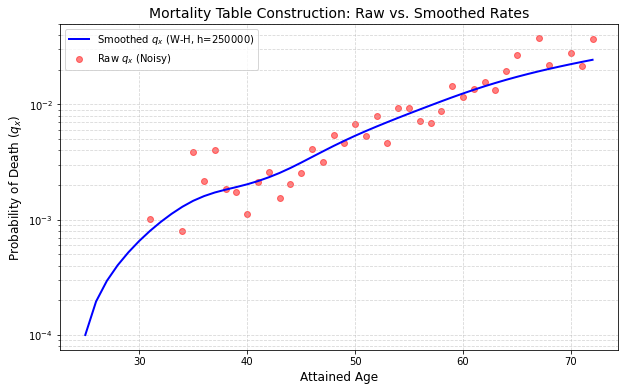

   Age  Exposure  Deaths   q_x_raw  q_x_smooth
0   25   530.321     0.0  0.000000    0.000100
1   26   607.560     0.0  0.000000    0.000195
2   27   666.095     0.0  0.000000    0.000295
3   28   727.631     0.0  0.000000    0.000402
4   29   793.938     0.0  0.000000    0.000521
5   30   884.944     0.0  0.000000    0.000654
6   31   980.193     1.0  0.001020    0.000799
7   32  1077.701     0.0  0.000000    0.000957
8   33  1182.927     0.0  0.000000    0.001124
9   34  1259.461     1.0  0.000794    0.001294


In [ ]:
# CALCULATE EXPOSURE (E_x) AND DEATHS (D_x) ---

# Range of attained ages in portfolio
min_age = df_portfolio['Issue_Age'].min()
max_age = int((df_portfolio['Issue_Age'] +
              df_portfolio['Duration_Years']).max())
ages = np.arange(min_age, max_age + 1)

E_x = np.zeros(len(ages))
D_x = np.zeros(len(ages))

# Distribute policyholders' exposure across attained ages
for index, row in df_portfolio.iterrows():
    issue_age = row['Issue_Age']
    duration = row['Duration_Years']
    status = row['Status']

    full_years = int(np.floor(duration))
    fractional_year = duration - full_years

    # Add 1 full year of exposure for every complete year lived
    for y in range(full_years):
        age_at_year = issue_age + y
        if age_at_year - min_age < len(ages):
            E_x[age_at_year - min_age] += 1.0

    # Exit
    exit_age = issue_age + full_years
    if exit_age - min_age < len(ages):
        if status == 'Dead':
            # Full year exposure in year of death
            E_x[exit_age - min_age] += 1.0
            D_x[exit_age - min_age] += 1.0  # Record the death
        else:
            # Partial exposure for Lapse/Active
            E_x[exit_age - min_age] += fractional_year

# Calculate Raw q_x (Avoid division by zero)
q_raw = np.divide(D_x, E_x, out=np.zeros_like(D_x), where=E_x > 0)

# We only graduate ages where we have credible exposure (e.g., E_x > 20)
valid_idx = E_x > 20
ages_to_grad = ages[valid_idx]
q_raw_to_grad = q_raw[valid_idx]
weights = E_x[valid_idx]


# WHITTAKER-HENDERSON GRADUATION ---

def whittaker_henderson_objective(q_hat, q_raw, weights, h):
    """ The Loss Function we want to minimize """
    # Fit: Weighted sum of squared errors
    fit = np.sum(weights * (q_raw - q_hat)**2)

    # Smoothness: Sum of squared second differences
    smoothness = h * np.sum(np.diff(q_hat, n=2)**2)

    return fit + smoothness


# Set the smoothing parameter (You can tweak this! 100k to 500k is typical for mortality)
h_parameter = 250000

# Initial guess
initial_guess = q_raw_to_grad.copy()

# Set bounds so mortality rates don't drop below 0.0001 or go above 1.0
bounds = [(0.0001, 0.999)] * len(q_raw_to_grad)

# Run the optimization solver (bounded optimization)
result = minimize(
    whittaker_henderson_objective,
    initial_guess,
    args=(q_raw_to_grad, weights, h_parameter),
    method='L-BFGS-B',
    bounds=bounds
)

q_smooth = result.x



plt.figure(figsize=(10, 6))
plt.scatter(ages_to_grad, q_raw_to_grad, color='red',
            alpha=0.5, label='Raw $q_x$ (Noisy)')
plt.plot(ages_to_grad, q_smooth, color='blue', linewidth=2,
         label=f'Smoothed $q_x$ (W-H, h={h_parameter})')
plt.yscale('log')  # Mortality is best viewed on a logarithmic scale
plt.xlabel('Attained Age', fontsize=12)
plt.ylabel('Probability of Death ($q_x$)', fontsize=12)
plt.title('Mortality Table Construction: Raw vs. Smoothed Rates', fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# Create the final Mortality Table DataFrame
df_mortality_table = pd.DataFrame({
    'Age': ages_to_grad,
    'Exposure': weights,
    'Deaths': D_x[valid_idx],
    'q_x_raw': q_raw_to_grad,
    'q_x_smooth': q_smooth
})
print(df_mortality_table.head(10))

In [ ]:
# PRICING THE TERM LIFE POLICY

# Parameters
issue_age = 40
term = 10
sum_assured = 150000  # $150,000 Death Benefit
interest_rate = 0.03  # 3% discount rate
v = 1 / (1 + interest_rate)

# 1. Extract the relevant q_x values from your smoothed table
# We need q_x for ages 40 to 49 (10 years)
q_x_10_years = df_mortality_table.loc[
    (df_mortality_table['Age'] >= issue_age) &
    (df_mortality_table['Age'] < issue_age + term),
    'q_x_smooth'
].values

# 2. Calculate survival probabilities (p_x) and cumulative survival (t_p_x)
p_x = 1 - q_x_10_years

# t_p_x is the probability of surviving 't' years from issue.
# _0p_x is 1.0 (100% alive at time 0).
t_p_x = np.cumprod(p_x)
t_p_x = np.insert(t_p_x, 0, 1.0)[:-1]  # Shift array so it starts with 1.0

# 3. Calculate Actuarial Present Values
A_factor = 0.0  # Present Value of Benefits
a_factor = 0.0  # Present Value of Premiums (Annuity)

for t in range(term):
    # Benefit is paid at the END of the year of death: discount v^(t+1)
    A_factor += (v ** (t + 1)) * t_p_x[t] * q_x_10_years[t]

    # Premium is paid at the BEGINNING of the year: discount v^t
    a_factor += (v ** t) * t_p_x[t]

# 4. Calculate the Premiums
net_premium = sum_assured * (A_factor / a_factor)

# Add 20% expense and safety loading for the Gross Premium
gross_premium = net_premium / 0.80

print(f"--- Pricing Results for {term}-Year Term Life ---")
print(f"Issue Age:   {issue_age}")
print(f"Sum Assured: €{sum_assured:,.2f}")
print(f"A factor:    {A_factor:.5f}")
print(f"a factor:    {a_factor:.5f}")
print(f"---------------------------------------------")
print(f"Net Premium (Prime Pure):        €{net_premium:,.2f} / year")
print(f"Gross Premium (Prime Commerciale): €{gross_premium:,.2f} / year")

--- Pricing Results for 10-Year Term Life ---
Issue Age:   40
Sum Assured: €150,000.00
A factor:    0.02592
a factor:    8.69095
---------------------------------------------
Net Premium (Prime Pure):        €447.44 / year
Gross Premium (Prime Commerciale): €559.30 / year


--- Mathematical Reserve Schedule ---
    End of Year (t)  Attained Age  Reserve (€)
0                 0            40         0.00
1                 1            41       157.35
2                 2            42       299.54
3                 3            43       420.97
4                 4            44       514.73
5                 5            45       572.09
6                 6            46       583.71
7                 7            47       540.41
8                 8            48       433.93
9                 9            49       256.12
10               10            50         0.00


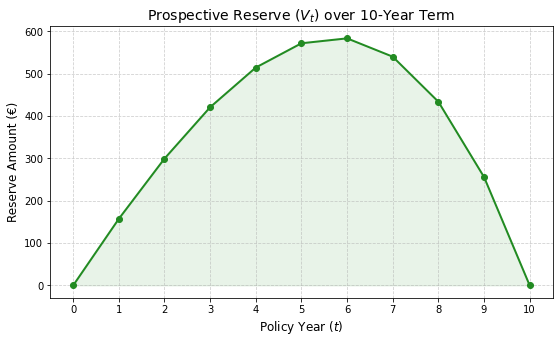

In [ ]:
# RESERVING

# Calculate the reserve at the END of each year t (from t=0 to 10)
reserves = np.zeros(term + 1)

# At t=0 and 10 , Reserve is 0 (Equivalence Principle and expiration)

for t in range(1, term):
    rem_term = term - t  # Remaining duration

    # Extract mortality rates for the remaining term
    q_x_rem = q_x_10_years[t:]
    p_x_rem = 1 - q_x_rem

    # Survival probabilities from time t
    t_p_x_rem = np.cumprod(p_x_rem)
    t_p_x_rem = np.insert(t_p_x_rem, 0, 1.0)[:-1]

    A_t = 0.0
    a_t = 0.0

    # Calculate Present Values for the remaining term
    for k in range(rem_term):
        A_t += (v ** (k + 1)) * t_p_x_rem[k] * q_x_rem[k]
        a_t += (v ** k) * t_p_x_rem[k]

    # Prospective Formula: Reserve = PVFB - PVFP
    reserves[t] = (sum_assured * A_t) - (net_premium * a_t)

# Display the Reserve Schedule
df_reserves = pd.DataFrame({
    'End of Year (t)': np.arange(term + 1),
    'Attained Age': np.arange(issue_age, issue_age + term + 1),
    'Reserve (€)': np.round(reserves, 2)
})

print("--- Mathematical Reserve Schedule ---")
print(df_reserves)

# --- VISUALIZE THE RESERVE CURVE ---
plt.figure(figsize=(9, 5))
x_vals = df_reserves['End of Year (t)'].to_numpy()
y_vals = df_reserves['Reserve (€)'].to_numpy()

# Plot the main line
plt.plot(x_vals, y_vals, marker='o', color='forestgreen', linewidth=2)
plt.title(f'Prospective Reserve ($V_t$) over {term}-Year Term', fontsize=14)
plt.xlabel('Policy Year ($t$)', fontsize=12)
plt.ylabel('Reserve Amount (€)', fontsize=12)
plt.xticks(np.arange(0, term + 1, 1))
plt.grid(True, linestyle='--', alpha=0.6)

# Fill the area under the curve to make it look professional
plt.fill_between(df_reserves['End of Year (t)'],
                 df_reserves['Reserve (€)'], color='forestgreen', alpha=0.1)

plt.show()